In [1]:
import os
import tensorflow as tf
import scipy.ndimage as ndi
from PIL import Image
from matplotlib import pyplot as plt
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

2025-03-26 06:31:11.057214: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-26 06:31:11.246630: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742970671.305251   25214 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742970671.322372   25214 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1742970671.452719   25214 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [2]:
IMGS_DIR = r'/mnt/d/Updated_Dataset/Images'
MASKS_DIR = r'/mnt/d/Updated_Dataset/Masks'
print(os.listdir(IMGS_DIR))
print(f"Total Imgs: {len(os.listdir(IMGS_DIR))} | Total Masks: {len(os.listdir(MASKS_DIR))}")

['P1', 'P10', 'P11', 'P12', 'P13', 'P14', 'P15', 'P16', 'P17', 'P18', 'P19', 'P2', 'P20', 'P21', 'P22', 'P23', 'P24', 'P25', 'P26', 'P27', 'P28', 'P29', 'P3', 'P30', 'P31', 'P32', 'P33', 'P34', 'P35', 'P36', 'P37', 'P38', 'P39', 'P4', 'P40', 'P41', 'P42', 'P43', 'P44', 'P45', 'P46', 'P47', 'P48', 'P49', 'P5', 'P50', 'P51', 'P52', 'P53', 'P54', 'P55', 'P56', 'P57', 'P58', 'P59', 'P6', 'P60', 'P61', 'P62', 'P63', 'P64', 'P65', 'P66', 'P67', 'P68', 'P69', 'P7', 'P70', 'P71', 'P72', 'P73', 'P74', 'P75', 'P76', 'P77', 'P78', 'P79', 'P8', 'P80', 'P81', 'P82', 'P83', 'P84', 'P85', 'P86', 'P9']
Total Imgs: 86 | Total Masks: 86


In [3]:
sample_img_path = f"{IMGS_DIR}/P1/"
os.listdir(sample_img_path)

['._adb-p1-img-366.png',
 'adb-p1-img-366.png',
 'adb-p1-img-370.png',
 'adb-p1-img-418.png']

In [4]:
sample_img_path = f"{IMGS_DIR}/P1/adb-p1-img-418.png"
sample_mask_path = f"{MASKS_DIR}/P1/ABD_LYMPH_Mask_418.png"

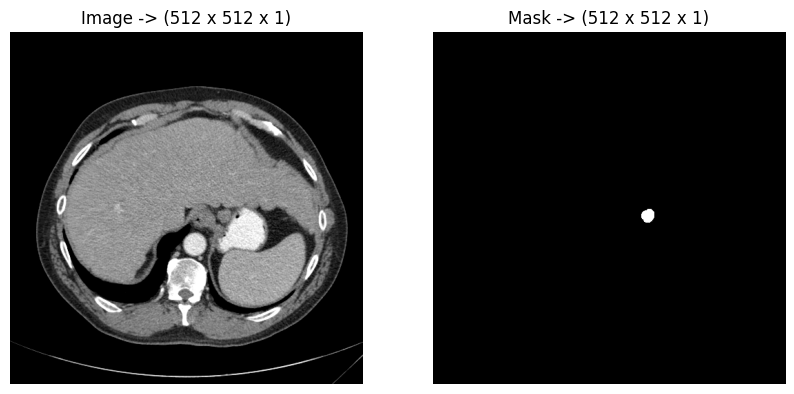

In [5]:
sample_img = Image.open(sample_img_path)
sample_mask = Image.open(sample_mask_path)

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(sample_img, cmap='gray')
plt.title(f"Image -> ({sample_img.height} x {sample_img.width} x {len(sample_img.getbands())})")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(sample_mask, cmap='gray')
plt.title(f"Mask -> ({sample_mask.height} x {sample_mask.width} x {len(sample_mask.getbands())})")
plt.axis('off')

plt.show()

In [6]:
IMAGE_SIZE = (256, 256)  # Match U-Net input size

def load_image(image_path):
    # img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Load CT in grayscale
    # img = cv2.resize(img, IMAGE_SIZE)  # Resize
    # img = img.astype(np.float32) / 255.0  # Normalize to [0,1]
    # return np.expand_dims(img, axis=-1)  # Keep (H, W, 1) shape
    if not os.path.exists(image_path):
        print(f"Error: Image file not found -> {image_path}")
        return None
    
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        print(f"Error: Failed to load image -> {image_path}")
        return None

    img = cv2.resize(img, IMAGE_SIZE)  # Resize
    img = img.astype(np.float32) / 255.0  # Normalize
    return np.expand_dims(img, axis=-1)


def load_mask(mask_path):
    # mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)  # Load mask
    # mask = cv2.resize(mask, IMAGE_SIZE)  # Resize
    # mask = (mask > 127).astype(np.uint8)  # Binarize (0 or 1)
    # return np.expand_dims(mask, axis=-1)
    if not os.path.exists(mask_path):
        print(f"Error: Mask file not found -> {mask_path}")
        return None

    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    if mask is None:
        print(f"Error: Failed to load mask -> {mask_path}")
        return None

    mask = cv2.resize(mask, IMAGE_SIZE)  # Resize
    mask = (mask > 127).astype(np.uint8)  # Binarize
    return np.expand_dims(mask, axis=-1)


# Function to get all image-mask pairs recursively
def get_image_mask_pairs(image_dir, mask_dir):
    image_mask_pairs = []

    # Iterate over patient folders
    for patient_id in sorted(os.listdir(image_dir)):  

        
        patient_image_path = os.path.join(image_dir, patient_id)
        patient_mask_path = os.path.join(mask_dir, patient_id)

        if not os.path.isdir(patient_image_path):
            continue
            
        print(patient_image_path)

        if not os.path.isdir(patient_image_path) or not os.path.isdir(patient_mask_path):
            continue  # Skip if not a directory

        # Get all images and masks in the patient folder
        image_files = sorted(os.listdir(patient_image_path))
        mask_files = sorted(os.listdir(patient_mask_path))

        print(image_files)

        # Ensure images and masks are paired correctly
        for img_file, mask_file in zip(image_files, mask_files):
            
            img_path = os.path.join(patient_image_path, img_file)
            mask_path = os.path.join(patient_mask_path, mask_file)

            if img_path.split("/")[-1][0] == ".":
                continue
            
            if img_path == "/kaggle/input/mdn-lymph-nodes/Images/Images/P1/._adb-p1-img-366.png":
                print(img_path)
                continue

            if os.path.exists(mask_path):  # Ensure mask exists
                image_mask_pairs.append((img_path, mask_path))

    return image_mask_pairs

In [23]:
image_mask_list = get_image_mask_pairs(IMGS_DIR, MASKS_DIR)

/mnt/d/Updated_Dataset/Images/P1
['._adb-p1-img-366.png', 'adb-p1-img-366.png', 'adb-p1-img-370.png', 'adb-p1-img-418.png']
/mnt/d/Updated_Dataset/Images/P10
['ABD_LYMPH_IMG_309.png', 'ABD_LYMPH_IMG_315.png', 'ABD_LYMPH_IMG_343.png', 'ABD_LYMPH_IMG_355.png']
/mnt/d/Updated_Dataset/Images/P11
['ABD_LYMPH_IMG_149.png', 'ABD_LYMPH_IMG_267.png', 'ABD_LYMPH_IMG_310.png', 'ABD_LYMPH_IMG_321.png', 'ABD_LYMPH_IMG_409.png', 'ABD_LYMPH_IMG_461.png']
/mnt/d/Updated_Dataset/Images/P12
['ABD_LYMPH_IMG_371.png']
/mnt/d/Updated_Dataset/Images/P13
['ABD_IMG_P13_171.png', 'ABD_IMG_P13_238.png', 'ABD_IMG_P13_245.png', 'ABD_IMG_P13_256.png', 'ABD_IMG_P13_265.png', 'ABD_IMG_P13_278.png', 'ABD_IMG_P13_285.png']
/mnt/d/Updated_Dataset/Images/P14
['ABD_LYMPH_IMG_021.png', 'ABD_LYMPH_IMG_031.png', 'ABD_LYMPH_IMG_042.png', 'ABD_LYMPH_IMG_084.png', 'ABD_LYMPH_IMG_087.png', 'ABD_LYMPH_IMG_096.png', 'ABD_LYMPH_IMG_097.png', 'ABD_LYMPH_IMG_110.png', 'ABD_LYMPH_IMG_115.png', 'ABD_LYMPH_IMG_162.png', 'ABD_LYMPH_IMG_

In [24]:
print(f"Total Images: {len(image_mask_list)}")
print(image_mask_list[4])

Total Images: 514
('/mnt/d/Updated_Dataset/Images/P10/ABD_LYMPH_IMG_315.png', '/mnt/d/Updated_Dataset/Masks/P10/ABD_LYMPH_Mask_315.png')


In [25]:
images = np.array([load_image(img_path) for img_path, _ in image_mask_list])
masks = np.array([load_mask(mask_path) for _, mask_path in image_mask_list])

masks = masks.astype("float32")
print(f"Images shape: {images.shape} & Masks shape: {masks.shape}")

Images shape: (514, 256, 256, 1) & Masks shape: (514, 256, 256, 1)


In [27]:
X_train, X_val, Y_train, Y_val = train_test_split(images, masks, test_size=0.1, random_state=42)
train_path, val_path = train_test_split(image_mask_list, test_size=0.1, random_state=42)

In [28]:
print(f"Train Images: {len(X_train)} | Train Masks: {len(Y_train)}\nTest Images: {len(X_val)} | Test Masks: {len(Y_val)}")

Train Images: 462 | Train Masks: 462
Test Images: 52 | Test Masks: 52


In [29]:
print(X_train.shape, Y_train.shape)
X_train[15, 156:200, 156:200]

(462, 256, 256, 1) (462, 256, 256, 1)


array([[[0.15686275],
        [0.14509805],
        [0.22352941],
        ...,
        [0.7607843 ],
        [0.7529412 ],
        [0.7294118 ]],

       [[0.16862746],
        [0.17254902],
        [0.22352941],
        ...,
        [0.7254902 ],
        [0.7411765 ],
        [0.7647059 ]],

       [[0.10588235],
        [0.16862746],
        [0.14509805],
        ...,
        [0.7254902 ],
        [0.7176471 ],
        [0.7490196 ]],

       ...,

       [[0.18431373],
        [0.23921569],
        [0.35686275],
        ...,
        [0.        ],
        [0.        ],
        [0.        ]],

       [[0.43529412],
        [0.4117647 ],
        [0.37254903],
        ...,
        [0.        ],
        [0.        ],
        [0.        ]],

       [[0.09803922],
        [0.        ],
        [0.        ],
        ...,
        [0.        ],
        [0.        ],
        [0.        ]]], dtype=float32)

In [30]:
print(X_val.shape, Y_val.shape)
X_val[10, :-50, :-10]

(52, 256, 256, 1) (52, 256, 256, 1)


array([[[0.        ],
        [0.        ],
        [0.        ],
        ...,
        [0.        ],
        [0.        ],
        [0.        ]],

       [[0.        ],
        [0.        ],
        [0.        ],
        ...,
        [0.        ],
        [0.        ],
        [0.        ]],

       [[0.        ],
        [0.        ],
        [0.        ],
        ...,
        [0.        ],
        [0.        ],
        [0.        ]],

       ...,

       [[0.        ],
        [0.        ],
        [0.        ],
        ...,
        [0.        ],
        [0.        ],
        [0.        ]],

       [[0.        ],
        [0.        ],
        [0.        ],
        ...,
        [0.        ],
        [0.        ],
        [0.25490198]],

       [[0.        ],
        [0.        ],
        [0.        ],
        ...,
        [0.24705882],
        [0.5803922 ],
        [0.3137255 ]]], dtype=float32)

In [ ]:
class ElasticDeformationAugmentation:
    def __init__(self, alpha=34, sigma=5, random_state=None):
        """
        Initialize Elastic Deformation Augmentation.
        
        Args:
            alpha (float): Scaling factor for deformation magnitude.
                Higher values create more dramatic deformations.
            sigma (float): Standard deviation for Gaussian filter.
                Controls the smoothness of deformations.
            random_state (int, optional): Seed for reproducibility.
        """
        self.alpha = alpha
        self.sigma = sigma
        self.random_state = random_state or np.random.randint(0, 2**32 - 1)
        
    def _generate_grid_displacement(self, shape):
        """
        Generate smooth random displacements using Gaussian filtering.
        
        Args:
            shape (tuple): Shape of the image (height, width)
        
        Returns:
            tuple: Displacement fields for x and y directions
        """
        # Set random seed for reproducibility
        np.random.seed(self.random_state)
        
        # Generate random displacement fields
        dx = np.random.rand(*shape) * 2 - 1
        dy = np.random.rand(*shape) * 2 - 1
        
        # Apply Gaussian filter to create smooth deformations
        # This creates spatially continuous, smooth deformations
        dx = ndi.gaussian_filter(dx, sigma=self.sigma) * self.alpha
        dy = ndi.gaussian_filter(dy, sigma=self.sigma) * self.alpha
        
        return dx, dy
    
    def _elastic_deform_2d(self, image, dx, dy):
        """
        Apply elastic deformation to a 2D image.
        
        Args:
            image (np.ndarray): Input 2D image
            dx (np.ndarray): Displacement in x-direction
            dy (np.ndarray): Displacement in y-direction
        
        Returns:
            np.ndarray: Deformed image
        """
        # Create coordinate grid
        x, y = np.meshgrid(np.arange(image.shape[1]), np.arange(image.shape[0]))
        
        # Apply displacements to coordinates
        deformed_x = x + dx
        deformed_y = y + dy
        
        # Interpolate deformed image
        deformed_image = ndi.map_coordinates(
            image, 
            [deformed_y, deformed_x], 
            order=1,  # Bilinear interpolation
            mode='nearest'  # Handling image boundary
        )
        
        return deformed_image
    
    def augment_images(self, images, masks):
        """
        Apply elastic deformation to images and masks.
        
        Args:
            images (np.ndarray): Input images (N, H, W, C)
            masks (np.ndarray): Corresponding masks (N, H, W, C)
        
        Returns:
            tuple: Deformed images and masks
        """
        deformed_images = []
        deformed_masks = []
        
        for img, mask in zip(images, masks):
            # Squeeze to 2D if needed (assuming single-channel images)
            img_2d = img.squeeze()
            mask_2d = mask.squeeze()
            
            # Generate displacement fields
            dx, dy = self._generate_grid_displacement(img_2d.shape)
            
            # Apply deformations
            deformed_img = self._elastic_deform_2d(img_2d, dx, dy)
            deformed_mask = self._elastic_deform_2d(mask_2d, dx, dy)
            
            # Restore original shape
            deformed_images.append(deformed_img[..., np.newaxis])
            deformed_masks.append(deformed_mask[..., np.newaxis])
        
        return np.array(deformed_images), np.array(deformed_masks)
    
    def generate_augmented_dataset(self, images, masks, augmentation_mode='multiply', target_size=None):
        """
        Generate an augmented dataset with elastic deformations.
        
        Args:
            images (np.ndarray): Original images
            masks (np.ndarray): Original masks
            augmentation_mode (str): Augmentation strategy
                - 'multiply': Generate multiple augmented samples per original image
                - 'expand': Expand dataset to a specific total number of images
            target_size (int, optional): 
                - If mode is 'multiply': Number of augmented samples per original image
                - If mode is 'expand': Total desired number of images in the final dataset
        
        Returns:
            tuple: Augmented images and masks
        """
        # Validate inputs
        if augmentation_mode not in ['multiply', 'expand']:
            raise ValueError("augmentation_mode must be either 'multiply' or 'expand'")
        
        # Determine augmentation strategy
        if augmentation_mode == 'multiply':
            # Default to 2 if not specified
            target_size = target_size if target_size else 2
            
            # Generate multiple augmented samples per original image
            all_augmented_images = [images]
            all_augmented_masks = [masks]
            
            for _ in range(target_size):
                aug_images, aug_masks = self.augment_images(images, masks)
                all_augmented_images.append(aug_images)
                all_augmented_masks.append(aug_masks)
            
            return np.concatenate(all_augmented_images), np.concatenate(all_augmented_masks)
        
        else:  # 'expand' mode
            # Calculate how many additional images we need to generate
            current_size = len(images)
            
            if target_size is None or target_size <= current_size:
                return images, masks
            
            additional_needed = target_size - current_size
            
            # Track augmented images
            all_augmented_images = [images]
            all_augmented_masks = [masks]
            
            # Generate additional images
            while len(all_augmented_images[0]) < target_size:
                # Generate augmentations
                aug_images, aug_masks = self.augment_images(images, masks)
                
                # Add augmented images
                all_augmented_images.append(aug_images)
                all_augmented_masks.append(aug_masks)
            
            # Concatenate and slice to exact target size
            augmented_images = np.concatenate(all_augmented_images)[:target_size]
            augmented_masks = np.concatenate(all_augmented_masks)[:target_size]
            
            return augmented_images, augmented_masks

In [32]:
# Example usage and visualization
def visualize_elastic_deformation(images, masks):
    """
    Visualize original and elastically deformed images.
    
    Args:
        images (np.ndarray): Original images
        masks (np.ndarray): Original masks
    """
    import matplotlib.pyplot as plt
    
    # Initialize elastic deformation augmenter
    augmenter = ElasticDeformationAugmentation(
        alpha=20,  # Deformation magnitude
        sigma=3    # Smoothness of deformation
    )
    
    # Generate deformed images
    deformed_images, deformed_masks = augmenter.augment_images(images, masks)
    
    # Plotting
    fig, axs = plt.subplots(2, 2, figsize=(10, 10))
    
    # Original image and mask
    axs[0, 0].imshow(images[0].squeeze(), cmap='gray')
    axs[0, 0].set_title('Original Image')
    axs[0, 1].imshow(masks[0].squeeze(), cmap='gray')
    axs[0, 1].set_title('Original Mask')
    
    # Deformed image and mask
    axs[1, 0].imshow(deformed_images[0].squeeze(), cmap='gray')
    axs[1, 0].set_title('Deformed Image')
    axs[1, 1].imshow(deformed_masks[0].squeeze(), cmap='gray')
    axs[1, 1].set_title('Deformed Mask')
    
    plt.tight_layout()
    plt.show()

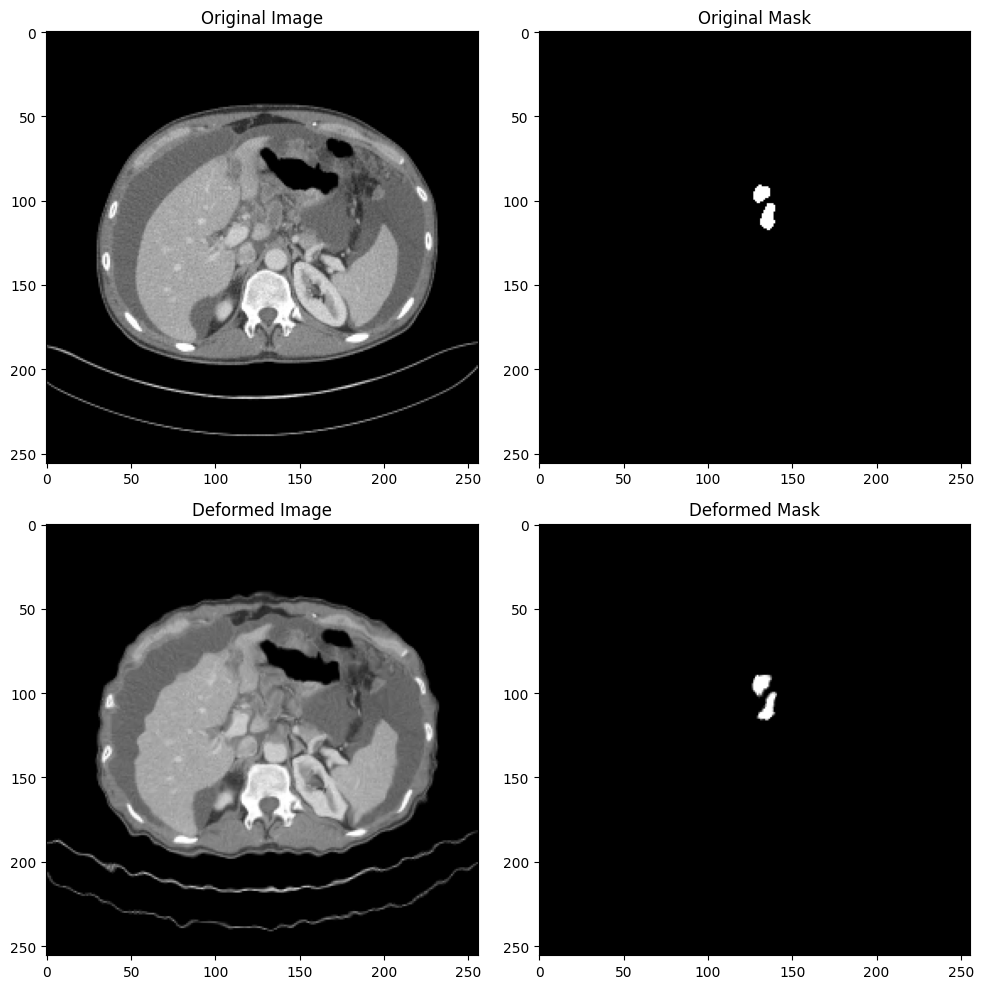

In [33]:
# Visualize elastic deformation
visualize_elastic_deformation(X_train, Y_train)

In [34]:
augmenter = ElasticDeformationAugmentation(
        alpha=20,  # Deformation magnitude
        sigma=3    # Smoothness of deformation
    )

In [35]:
augmented_images, augmented_masks = augmenter.generate_augmented_dataset(
        X_train, Y_train,
        augmentation_mode='multiply',
        target_size=5
    )

In [37]:
print("Original images shape:", X_train.shape)
print("Augmented images shape:", augmented_images.shape)

Original images shape: (462, 256, 256, 1)
Augmented images shape: (2772, 256, 256, 1)


In [38]:
(462*5) + 462

2772